In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    

    return X_train,  X_test, y_train,  y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [12]:
# Initializing parameters
epochs = 25
batch_size = 16
n_hidden = 32
timesteps=128
input_dim = 9
n_classes = 6

In [12]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [13]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\mushtaq\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [15]:
import pickle as pkl

#to save it
with open("har_data.pkl", "wb") as f:
    pkl.dump([X_train, X_test, Y_train, Y_test], f)

### Defining the Architecture of LSTM

In [15]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [17]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/25
7352/7352 [==============================] - 34s 5ms/step - loss: 1.3139 - acc: 0.4358 - val_loss: 1.1352 - val_acc: 0.4700
Epoch 2/25
7352/7352 [==============================] - 33s 4ms/step - loss: 0.9788 - acc: 0.5773 - val_loss: 0.9513 - val_acc: 0.5884
Epoch 3/25
7352/7352 [==============================] - 36s 5ms/step - loss: 0.7977 - acc: 0.6457 - val_loss: 0.8343 - val_acc: 0.6013
Epoch 4/25
7352/7352 [==============================] - 41s 6ms/step - loss: 0.6989 - acc: 0.6582 - val_loss: 0.7532 - val_acc: 0.6098
Epoch 5/25
7352/7352 [==============================] - 41s 6ms/step - loss: 0.6359 - acc: 0.6797 - val_loss: 0.7335 - val_acc: 0.6183
Epoch 6/25
7352/7352 [==============================] - 41s 6ms/step - loss: 0.5819 - acc: 0.6865 - val_loss: 0.8786 - val_acc: 0.6098
Epoch 7/25
7352/7352 [==============================] - 41s 6ms/step - loss: 0.5676 - acc: 0.7058 - val_loss: 0.8191 - val_acc: 0.6132
Epoch 8

In [14]:
# This function plots the confusion matrices
def plot_confusion_matrix(y_test, y_predict):
    C = confusion_matrix(y_test, y_predict)
    # C = 6,6 matrix, each cell (i,j) represents number of points of class i are predicted class j
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = ['LAYING' , 'SITTING',  'STANDING', 'WALKING',  'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']         
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

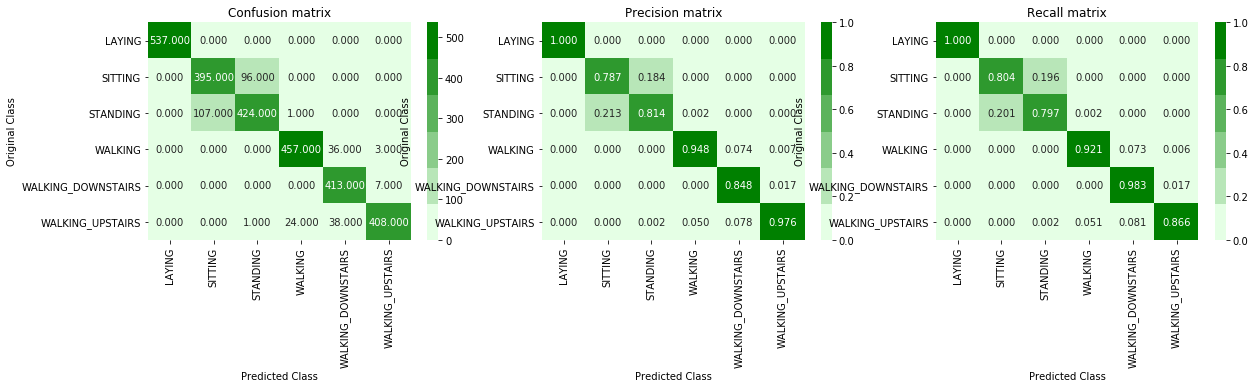

In [19]:
# Confusion Matrix
plot_confusion_matrix(Y_test, model.predict(X_test))

In [20]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 419us/step


In [21]:
score

[0.4131409560204217, 0.8937902952154734]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

# --------------------------------------------------------------------------------------

# Hyperparameter Tuning

### HyperParameter : Dropout (Uniform) and Batch Size

In [15]:
import pickle as pkl
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    # Loading the train and test data
    X_train, X_test, Y_train, Y_test = pkl.load(open('har_data.pkl', 'rb'))
    
    return X_train, X_test, Y_train,Y_test 

In [26]:
# Importing Libraries

In [16]:
from hyperopt import Trials, STATUS_OK, tpe, space_eval
import keras.optimizers, keras.initializers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
 
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
import numpy, json 

### Model Architecture

In [24]:
def model(X_train, X_test, Y_train,Y_test):
    model = Sequential()
    model.add(LSTM(128, input_shape=(128, 9)))  # one Lstm Layer
    model.add(Dropout({{uniform(0, 1)}}))       # Uniform Dropout between 0 an 1
    model.add(Dense(6, activation='sigmoid'))   # Activation sigmoid

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',                          #Optimzer is adam
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

    model.fit(X_train, Y_train,
              batch_size={{choice([32, 64, 128])}},        # Different batch sizes
              epochs=20,
              validation_split=0.08,                       # splitting data into 80:20 ratio for train and validation
              callbacks=[early_stopping, checkpointer])

    score, acc = model.evaluate(X_test, Y_test, verbose=0)

    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}   

### Finding Best Parameters and Corresponding Best Model

In [25]:
best_run, best_model = optim.minimize(model=model,
                                          data = data,
                                          algo=tpe.suggest,
                                          max_evals=30,
                                          trials=Trials(),
                                          notebook_name='HAR_LSTM')  # saving to Har_LSTM


>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    import pickle as pkl
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import pickle as pkl
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice


Epoch 00008: val_loss did not improve from 0.26158
Epoch 9/20
6763/6763 [==============================] - 37s 6ms/step - loss: 0.2559 - acc: 0.8881 - val_loss: 0.2931 - val_acc: 0.8729

Epoch 00009: val_loss did not improve from 0.26158
Epoch 10/20
6763/6763 [==============================] - 37s 6ms/step - loss: 0.2981 - acc: 0.8682 - val_loss: 0.2559 - val_acc: 0.8662

Epoch 00010: val_loss improved from 0.26158 to 0.25593, saving model to keras_weights.hdf5
Epoch 11/20
6763/6763 [==============================] - 37s 6ms/step - loss: 0.2379 - acc: 0.8886 - val_loss: 0.2085 - val_acc: 0.9010

Epoch 00011: val_loss improved from 0.25593 to 0.20854, saving model to keras_weights.hdf5
Epoch 12/20
6763/6763 [==============================] - 37s 6ms/step - loss: 0.2159 - acc: 0.8993 - val_loss: 0.2128 - val_acc: 0.9004

Epoch 00012: val_loss did not improve from 0.20854
Epoch 13/20
6763/6763 [==============================] - 37s 6ms/step - loss: 0.2301 - acc: 0.8965 - val_loss: 0.1898

6763/6763 [==============================] - 47s 7ms/step - loss: 0.0562 - acc: 0.9799 - val_loss: 0.0417 - val_acc: 0.9842

Epoch 00016: val_loss improved from 0.04980 to 0.04174, saving model to keras_weights.hdf5
Epoch 17/20
6763/6763 [==============================] - 47s 7ms/step - loss: 0.0716 - acc: 0.9745 - val_loss: 0.0505 - val_acc: 0.9856

Epoch 00017: val_loss did not improve from 0.04174
Epoch 18/20
6763/6763 [==============================] - 47s 7ms/step - loss: 0.0839 - acc: 0.9738 - val_loss: 0.0524 - val_acc: 0.9810

Epoch 00018: val_loss did not improve from 0.04174
Epoch 19/20
6763/6763 [==============================] - 47s 7ms/step - loss: 0.0605 - acc: 0.9791 - val_loss: 0.0564 - val_acc: 0.9663

Epoch 00019: val_loss did not improve from 0.04174
Epoch 20/20
6763/6763 [==============================] - 47s 7ms/step - loss: 0.0552 - acc: 0.9805 - val_loss: 0.0419 - val_acc: 0.9785

Epoch 00020: val_loss did not improve from 0.04174
Test accuracy: 0.967424507257612

6763/6763 [==============================] - 57s 8ms/step - loss: 0.1930 - acc: 0.9184 - val_loss: 0.1768 - val_acc: 0.9273

Epoch 00015: val_loss improved from 0.18758 to 0.17685, saving model to keras_weights.hdf5
Epoch 16/20
6763/6763 [==============================] - 54s 8ms/step - loss: 0.1803 - acc: 0.9250 - val_loss: 0.2099 - val_acc: 0.9174

Epoch 00016: val_loss did not improve from 0.17685
Epoch 17/20
6763/6763 [==============================] - 53s 8ms/step - loss: 0.1836 - acc: 0.9282 - val_loss: 0.1013 - val_acc: 0.9638

Epoch 00017: val_loss improved from 0.17685 to 0.10128, saving model to keras_weights.hdf5
Epoch 18/20
6763/6763 [==============================] - 53s 8ms/step - loss: 0.1300 - acc: 0.9533 - val_loss: 0.0969 - val_acc: 0.9615

Epoch 00018: val_loss improved from 0.10128 to 0.09692, saving model to keras_weights.hdf5
Epoch 19/20
6763/6763 [==============================] - 51s 8ms/step - loss: 0.1335 - acc: 0.9557 - val_loss: 0.1251 - val_acc: 0.9400

Epo

6763/6763 [==============================] - 50s 7ms/step - loss: 0.3438 - acc: 0.8620 - val_loss: 0.3003 - val_acc: 0.8625

Epoch 00003: val_loss did not improve from 0.29287
Epoch 4/20
6763/6763 [==============================] - 50s 7ms/step - loss: 0.3736 - acc: 0.8468 - val_loss: 0.3574 - val_acc: 0.8333

Epoch 00004: val_loss did not improve from 0.29287
Epoch 5/20
6763/6763 [==============================] - 50s 7ms/step - loss: 0.3687 - acc: 0.8461 - val_loss: 0.3248 - val_acc: 0.8613

Epoch 00005: val_loss did not improve from 0.29287
Epoch 6/20
6763/6763 [==============================] - 50s 7ms/step - loss: 0.3133 - acc: 0.8692 - val_loss: 0.2710 - val_acc: 0.8840

Epoch 00006: val_loss improved from 0.29287 to 0.27099, saving model to keras_weights.hdf5
Epoch 7/20
6763/6763 [==============================] - 50s 7ms/step - loss: 0.2854 - acc: 0.8740 - val_loss: 0.2525 - val_acc: 0.8710

Epoch 00007: val_loss improved from 0.27099 to 0.25249, saving model to keras_weights.h

6763/6763 [==============================] - 51s 8ms/step - loss: 0.0769 - acc: 0.9716 - val_loss: 0.0672 - val_acc: 0.9830

Epoch 00013: val_loss did not improve from 0.04988
Epoch 14/20
6763/6763 [==============================] - 51s 8ms/step - loss: 0.0670 - acc: 0.9789 - val_loss: 0.0426 - val_acc: 0.9861

Epoch 00014: val_loss improved from 0.04988 to 0.04256, saving model to keras_weights.hdf5
Epoch 15/20
6763/6763 [==============================] - 51s 8ms/step - loss: 0.0738 - acc: 0.9724 - val_loss: 0.1147 - val_acc: 0.9502

Epoch 00015: val_loss did not improve from 0.04256
Epoch 16/20
6763/6763 [==============================] - 56s 8ms/step - loss: 0.0722 - acc: 0.9753 - val_loss: 0.0659 - val_acc: 0.9734

Epoch 00016: val_loss did not improve from 0.04256
Epoch 17/20
6763/6763 [==============================] - 51s 8ms/step - loss: 0.0573 - acc: 0.9795 - val_loss: 0.0387 - val_acc: 0.9808

Epoch 00017: val_loss improved from 0.04256 to 0.03869, saving model to keras_weigh

6763/6763 [==============================] - 43s 6ms/step - loss: 0.2951 - acc: 0.8679 - val_loss: 0.2589 - val_acc: 0.8930

Epoch 00012: val_loss did not improve from 0.19542
Epoch 13/20
6763/6763 [==============================] - 42s 6ms/step - loss: 0.2806 - acc: 0.8669 - val_loss: 0.2464 - val_acc: 0.8809

Epoch 00013: val_loss did not improve from 0.19542
Epoch 14/20
6763/6763 [==============================] - 42s 6ms/step - loss: 0.2242 - acc: 0.8971 - val_loss: 0.1606 - val_acc: 0.9457

Epoch 00014: val_loss improved from 0.19542 to 0.16058, saving model to keras_weights.hdf5
Epoch 15/20
6763/6763 [==============================] - 42s 6ms/step - loss: 0.1899 - acc: 0.9162 - val_loss: 0.1589 - val_acc: 0.9202

Epoch 00015: val_loss improved from 0.16058 to 0.15894, saving model to keras_weights.hdf5
Epoch 16/20
6763/6763 [==============================] - 43s 6ms/step - loss: 0.1468 - acc: 0.9412 - val_loss: 0.1588 - val_acc: 0.9202

Epoch 00016: val_loss improved from 0.15894

6763/6763 [==============================] - 43s 6ms/step - loss: 0.0657 - acc: 0.9769 - val_loss: 0.0536 - val_acc: 0.9785

Epoch 00020: val_loss did not improve from 0.05141
Test accuracy: 0.9593937384867854
Train on 6763 samples, validate on 589 samples
Epoch 1/20
6763/6763 [==============================] - 44s 7ms/step - loss: 0.4247 - acc: 0.8378 - val_loss: 0.3400 - val_acc: 0.8613

Epoch 00001: val_loss improved from inf to 0.34005, saving model to keras_weights.hdf5
Epoch 2/20
6763/6763 [==============================] - 41s 6ms/step - loss: 0.3604 - acc: 0.8584 - val_loss: 0.3561 - val_acc: 0.8580

Epoch 00002: val_loss did not improve from 0.34005
Epoch 3/20
6763/6763 [==============================] - 41s 6ms/step - loss: 0.3416 - acc: 0.8628 - val_loss: 0.3332 - val_acc: 0.8676

Epoch 00003: val_loss improved from 0.34005 to 0.33321, saving model to keras_weights.hdf5
Epoch 4/20
6763/6763 [==============================] - 41s 6ms/step - loss: 0.3157 - acc: 0.8755 - val_lo

### Printing Best parameters

In [28]:
print(best_run)  

{'Dropout': 0.39730440328653105, 'batch_size': 0}


best batch size is 32

### Performing best model on our test set

In [29]:
X_train, X_test, Y_train,Y_test = data()
print("Evaluation of best performing model:")
    
print(best_model.evaluate(X_test, Y_test,verbose=0))
print("Best performing model chosen hyper-parameters:")
print(best_run)
json.dump(best_run, open("best_run1.txt", 'w'))

Evaluation of best performing model:
[0.07511318304856766, 0.9704219014271664]
Best performing model chosen hyper-parameters:
{'Dropout': 0.39730440328653105, 'batch_size': 0}


Loss and accuracy both improved

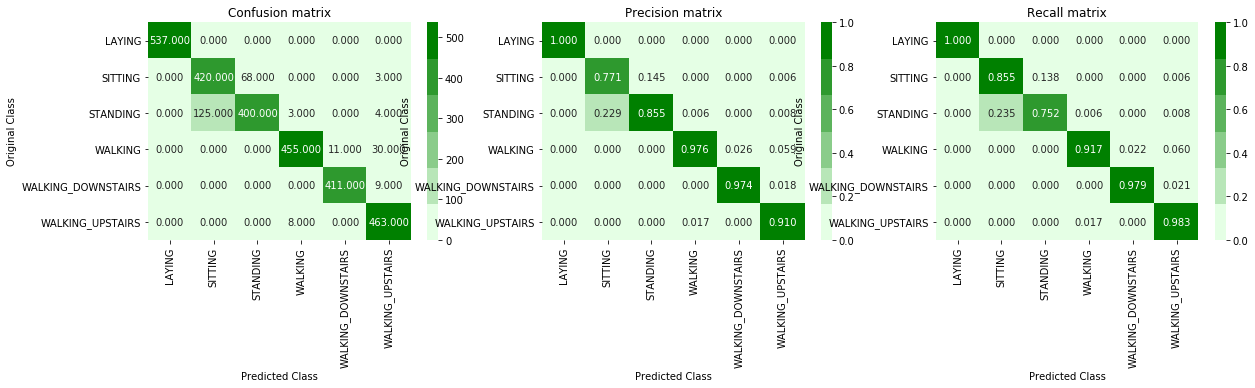

In [32]:
# Confusion Matrix
plot_confusion_matrix(Y_test, best_model.predict(X_test))

## Hyperparameter Tuning on more parameters

### Hyperparameter: 

#### 1. Number of lstm units,

#### 2. Number of lstm layers,

#### 3. Optimzer : Adam or  RMSProp or  SGD with different learning rates

#### 4. Batch Size

Dropout is fixed here 0.5

### Model Architecture

In [17]:
def model2(X_train, X_test, Y_train,Y_test):
    model = Sequential()
    model.add(LSTM({{choice([32, 64, 128])}}, input_shape=(128,9), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
 
    if conditional({{choice(['one', 'two'])}}) == 'two':
        model.add(Dense({{choice([32,64, 128])}}))
        model.add(Dropout(0.5))
        model.add(Activation('relu'))
 
    model.add(Dense(6))
    model.add(Activation('softmax'))
 
    adam = keras.optimizers.Adam(lr={{choice([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])}}, clipnorm=1.)
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])}}, clipnorm=1.)
    sgd = keras.optimizers.SGD(lr={{choice([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])}}, clipnorm=1.)
 
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer=optim)
 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    checkpointer = ModelCheckpoint(filepath='keras_lstm_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

    model.fit(X_train, Y_train,
              batch_size={{choice([32, 64, 128])}},
              epochs=20,
              validation_split=0.08,
              callbacks=[early_stopping, checkpointer])

    score, acc = model.evaluate(X_test, Y_test, verbose=0)

    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

### Finding Best Parameters and corresponding Best Model

In [18]:
best_run2, best_model2 = optim.minimize(model=model2, #A function defining a keras model with hyperas templates, which returns a valid hyperopt results dictionary, e.g. return {‘loss’: -acc, ‘status’: STATUS_OK}
                                          data = data,  #A parameter-less function that defines and return all data needed in the above model definition
                                          algo=tpe.suggest,# Tree-structured Parzen Estimator (TPE) algorithm is a bayesian algorithm 
                                          max_evals=30,  #we use at most 30 evaluation runs for optimization.
                                          trials=Trials(),  #A hyperopt Trials object, used to store intermediate results for all optimization runs
                                          notebook_name='HAR_LSTM') # If running from an ipython notebook, provide filename (not path)


>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    import pickle as pkl
except:
    pass

try:
    import pickle as pkl
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe, space_eval
except:
    pass

try:
    import keras.optimizers, keras.initializers
except:
    pass

try:
    from keras.regularizers import l2
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ModelCheckpoint
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from ke

6763/6763 [==============================] - 26s 4ms/step - loss: 1.7971 - acc: 0.1425 - val_loss: 1.7924 - val_acc: 0.1715

Epoch 00018: val_loss improved from 1.79247 to 1.79243, saving model to keras_lstm_weights.hdf5
Epoch 19/20
6763/6763 [==============================] - 26s 4ms/step - loss: 1.7963 - acc: 0.1372 - val_loss: 1.7924 - val_acc: 0.1732

Epoch 00019: val_loss improved from 1.79243 to 1.79239, saving model to keras_lstm_weights.hdf5
Epoch 20/20
6763/6763 [==============================] - 26s 4ms/step - loss: 1.7970 - acc: 0.1403 - val_loss: 1.7923 - val_acc: 0.1749

Epoch 00020: val_loss improved from 1.79239 to 1.79235, saving model to keras_lstm_weights.hdf5
Test accuracy: 0.16185951815405497
Train on 6763 samples, validate on 589 samples
Epoch 1/20
6763/6763 [==============================] - 24s 3ms/step - loss: 1.7751 - acc: 0.1971 - val_loss: 1.7617 - val_acc: 0.4160

Epoch 00001: val_loss improved from inf to 1.76174, saving model to keras_lstm_weights.hdf5
Epo

6763/6763 [==============================] - 30s 4ms/step - loss: 0.1603 - acc: 0.9386 - val_loss: 0.1054 - val_acc: 0.9389

Epoch 00012: val_loss did not improve from 0.09420
Epoch 13/20
6763/6763 [==============================] - 30s 4ms/step - loss: 0.1311 - acc: 0.9500 - val_loss: 0.1167 - val_acc: 0.9389

Epoch 00013: val_loss did not improve from 0.09420
Epoch 14/20
6763/6763 [==============================] - 30s 4ms/step - loss: 0.2051 - acc: 0.9440 - val_loss: 0.1635 - val_acc: 0.8879

Epoch 00014: val_loss did not improve from 0.09420
Epoch 15/20
6763/6763 [==============================] - 30s 4ms/step - loss: 0.2491 - acc: 0.9407 - val_loss: 0.0827 - val_acc: 0.9491

Epoch 00015: val_loss improved from 0.09420 to 0.08272, saving model to keras_lstm_weights.hdf5
Epoch 16/20
6763/6763 [==============================] - 30s 4ms/step - loss: 0.2827 - acc: 0.9341 - val_loss: 0.1390 - val_acc: 0.9015

Epoch 00016: val_loss did not improve from 0.08272
Epoch 17/20
6763/6763 [====


Epoch 00005: val_loss improved from 1.55218 to 1.49337, saving model to keras_lstm_weights.hdf5
Epoch 6/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.4839 - acc: 0.3985 - val_loss: 1.4425 - val_acc: 0.4890

Epoch 00006: val_loss improved from 1.49337 to 1.44249, saving model to keras_lstm_weights.hdf5
Epoch 7/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.4415 - acc: 0.4096 - val_loss: 1.3935 - val_acc: 0.4839

Epoch 00007: val_loss improved from 1.44249 to 1.39349, saving model to keras_lstm_weights.hdf5
Epoch 8/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.3934 - acc: 0.4306 - val_loss: 1.3385 - val_acc: 0.5229

Epoch 00008: val_loss improved from 1.39349 to 1.33845, saving model to keras_lstm_weights.hdf5
Epoch 9/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.3530 - acc: 0.4446 - val_loss: 1.2846 - val_acc: 0.5382

Epoch 00009: val_loss improved from 1.33845 to 1.28462, saving model to ker

6763/6763 [==============================] - 14s 2ms/step - loss: 1.7855 - acc: 0.2008 - val_loss: 1.7729 - val_acc: 0.2954

Epoch 00019: val_loss improved from 1.77296 to 1.77293, saving model to keras_lstm_weights.hdf5
Epoch 20/20
6763/6763 [==============================] - 15s 2ms/step - loss: 1.7870 - acc: 0.2033 - val_loss: 1.7729 - val_acc: 0.2954

Epoch 00020: val_loss improved from 1.77293 to 1.77290, saving model to keras_lstm_weights.hdf5
Test accuracy: 0.22667119104173736
Train on 6763 samples, validate on 589 samples
Epoch 1/20
6763/6763 [==============================] - 22s 3ms/step - loss: 1.7984 - acc: 0.1665 - val_loss: 1.7937 - val_acc: 0.2462

Epoch 00001: val_loss improved from inf to 1.79366, saving model to keras_lstm_weights.hdf5
Epoch 2/20
6763/6763 [==============================] - 20s 3ms/step - loss: 1.7874 - acc: 0.2138 - val_loss: 1.7822 - val_acc: 0.3226

Epoch 00002: val_loss improved from 1.79366 to 1.78217, saving model to keras_lstm_weights.hdf5
Epoc


Epoch 00013: val_loss improved from 1.77359 to 1.77173, saving model to keras_lstm_weights.hdf5
Epoch 14/20
6763/6763 [==============================] - 6s 944us/step - loss: 1.7854 - acc: 0.1712 - val_loss: 1.7699 - val_acc: 0.2360

Epoch 00014: val_loss improved from 1.77173 to 1.76991, saving model to keras_lstm_weights.hdf5
Epoch 15/20
6763/6763 [==============================] - 6s 943us/step - loss: 1.7799 - acc: 0.1904 - val_loss: 1.7680 - val_acc: 0.2360

Epoch 00015: val_loss improved from 1.76991 to 1.76803, saving model to keras_lstm_weights.hdf5
Epoch 16/20
6763/6763 [==============================] - 6s 948us/step - loss: 1.7799 - acc: 0.1902 - val_loss: 1.7662 - val_acc: 0.2360

Epoch 00016: val_loss improved from 1.76803 to 1.76617, saving model to keras_lstm_weights.hdf5
Epoch 17/20
6763/6763 [==============================] - 6s 944us/step - loss: 1.7789 - acc: 0.1873 - val_loss: 1.7644 - val_acc: 0.2377

Epoch 00017: val_loss improved from 1.76617 to 1.76435, saving 

6763/6763 [==============================] - 9s 1ms/step - loss: 1.7904 - acc: 0.1912 - val_loss: 1.7945 - val_acc: 0.1375

Epoch 00003: val_loss improved from 1.79498 to 1.79453, saving model to keras_lstm_weights.hdf5
Epoch 4/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.7918 - acc: 0.1822 - val_loss: 1.7941 - val_acc: 0.1375

Epoch 00004: val_loss improved from 1.79453 to 1.79408, saving model to keras_lstm_weights.hdf5
Epoch 5/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.7886 - acc: 0.1860 - val_loss: 1.7936 - val_acc: 0.1341

Epoch 00005: val_loss improved from 1.79408 to 1.79363, saving model to keras_lstm_weights.hdf5
Epoch 6/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.7891 - acc: 0.1819 - val_loss: 1.7932 - val_acc: 0.1341

Epoch 00006: val_loss improved from 1.79363 to 1.79319, saving model to keras_lstm_weights.hdf5
Epoch 7/20
6763/6763 [==============================] - 9s 1ms/step - loss: 1.7889 - ac

6763/6763 [==============================] - 52s 8ms/step - loss: 1.0648 - acc: 0.5459 - val_loss: 1.0597 - val_acc: 0.4788

Epoch 00019: val_loss improved from 1.08315 to 1.05975, saving model to keras_lstm_weights.hdf5
Epoch 20/20
6763/6763 [==============================] - 56s 8ms/step - loss: 1.0562 - acc: 0.5512 - val_loss: 1.0415 - val_acc: 0.4771

Epoch 00020: val_loss improved from 1.05975 to 1.04145, saving model to keras_lstm_weights.hdf5
Test accuracy: 0.5191720393620631
Train on 6763 samples, validate on 589 samples
Epoch 1/20
6763/6763 [==============================] - 17s 2ms/step - loss: 1.7883 - acc: 0.1884 - val_loss: 1.7879 - val_acc: 0.2343

Epoch 00001: val_loss improved from inf to 1.78786, saving model to keras_lstm_weights.hdf5
Epoch 2/20
6763/6763 [==============================] - 14s 2ms/step - loss: 1.7904 - acc: 0.1771 - val_loss: 1.7876 - val_acc: 0.2343

Epoch 00002: val_loss improved from 1.78786 to 1.78756, saving model to keras_lstm_weights.hdf5
Epoch

6763/6763 [==============================] - 20s 3ms/step - loss: 0.1940 - acc: 0.9440 - val_loss: 0.1762 - val_acc: 0.8998

Epoch 00010: val_loss did not improve from 0.08651
Epoch 11/20
6763/6763 [==============================] - 21s 3ms/step - loss: 0.1837 - acc: 0.9450 - val_loss: 0.1186 - val_acc: 0.9440

Epoch 00011: val_loss did not improve from 0.08651
Epoch 12/20
6763/6763 [==============================] - 21s 3ms/step - loss: 0.1821 - acc: 0.9477 - val_loss: 0.1258 - val_acc: 0.9474

Epoch 00012: val_loss did not improve from 0.08651
Epoch 13/20
6763/6763 [==============================] - 21s 3ms/step - loss: 0.1526 - acc: 0.9500 - val_loss: 0.1202 - val_acc: 0.9677

Epoch 00013: val_loss did not improve from 0.08651
Epoch 14/20
6763/6763 [==============================] - 20s 3ms/step - loss: 0.2015 - acc: 0.9456 - val_loss: 0.1285 - val_acc: 0.9049

Epoch 00014: val_loss did not improve from 0.08651
Epoch 15/20
6763/6763 [==============================] - 21s 3ms/step - 

6763/6763 [==============================] - 14s 2ms/step - loss: 0.4310 - acc: 0.8748 - val_loss: 0.2052 - val_acc: 0.9236

Epoch 00009: val_loss improved from 0.50538 to 0.20523, saving model to keras_lstm_weights.hdf5
Epoch 10/20
6763/6763 [==============================] - 14s 2ms/step - loss: 0.3736 - acc: 0.8937 - val_loss: 0.3208 - val_acc: 0.8608

Epoch 00010: val_loss did not improve from 0.20523
Epoch 11/20
6763/6763 [==============================] - 14s 2ms/step - loss: 0.2842 - acc: 0.9138 - val_loss: 0.2122 - val_acc: 0.9287

Epoch 00011: val_loss did not improve from 0.20523
Epoch 12/20
6763/6763 [==============================] - 14s 2ms/step - loss: 0.2940 - acc: 0.9160 - val_loss: 0.1986 - val_acc: 0.9474

Epoch 00012: val_loss improved from 0.20523 to 0.19857, saving model to keras_lstm_weights.hdf5
Epoch 13/20
6763/6763 [==============================] - 14s 2ms/step - loss: 0.2590 - acc: 0.9179 - val_loss: 0.1599 - val_acc: 0.9304

Epoch 00013: val_loss improved fr

Epoch 4/20
6763/6763 [==============================] - 57s 8ms/step - loss: 0.5558 - acc: 0.8067 - val_loss: 0.2190 - val_acc: 0.9338

Epoch 00004: val_loss improved from 0.43485 to 0.21896, saving model to keras_lstm_weights.hdf5
Epoch 5/20
6763/6763 [==============================] - 60s 9ms/step - loss: 0.2734 - acc: 0.9102 - val_loss: 0.1504 - val_acc: 0.9219

Epoch 00005: val_loss improved from 0.21896 to 0.15042, saving model to keras_lstm_weights.hdf5
Epoch 6/20
6763/6763 [==============================] - 60s 9ms/step - loss: 0.2355 - acc: 0.9261 - val_loss: 0.1906 - val_acc: 0.9304

Epoch 00006: val_loss did not improve from 0.15042
Epoch 7/20
6763/6763 [==============================] - 61s 9ms/step - loss: 0.2329 - acc: 0.9268 - val_loss: 0.1710 - val_acc: 0.9083

Epoch 00007: val_loss did not improve from 0.15042
Epoch 8/20
6763/6763 [==============================] - 61s 9ms/step - loss: 0.2146 - acc: 0.9318 - val_loss: 0.1219 - val_acc: 0.9440

Epoch 00008: val_loss impr

### Best Parameters

In [19]:
print(best_run2)

{'Dense': 2, 'LSTM': 2, 'LSTM_1': 1, 'choiceval': 0, 'conditional': 0, 'lr': 3, 'lr_1': 5, 'lr_2': 3}


Dense:2          means   2-hidden layer

LSTM :2          means   128 units of LSTM

LSTM_1:1         means   no. of LSTM units in second layer which is 64 here

Choiceval:0      means   Adam

Conditional :0   means   Adding 1 layer if it will be 1 means we need to to add 2 layer

lr:3             means   Adam with learning rate 10**-3

lr_1:5           means   RMSProp with learning rate 10**-1

lr_2:3           means   SGD with learning rate 10**-3


### Performing Best Model on Test data

In [22]:
X_train, X_test, Y_train,Y_test = data()
print("Evaluation of best performing model:")
    
print(best_model2.evaluate(X_test, Y_test,verbose=0))
print("---------------------------------------------------------------------")
print("Best performing model chosen hyper-parameters:")
print(best_run2)
json.dump(best_run2, open("best_run.txt", 'w'))

Evaluation of best performing model:
[0.3377331184284287, 0.9104173736002714]
---------------------------------------------------------------------
Best performing model chosen hyper-parameters:
{'Dense': 2, 'LSTM': 2, 'LSTM_1': 1, 'choiceval': 0, 'conditional': 0, 'lr': 3, 'lr_1': 5, 'lr_2': 3}


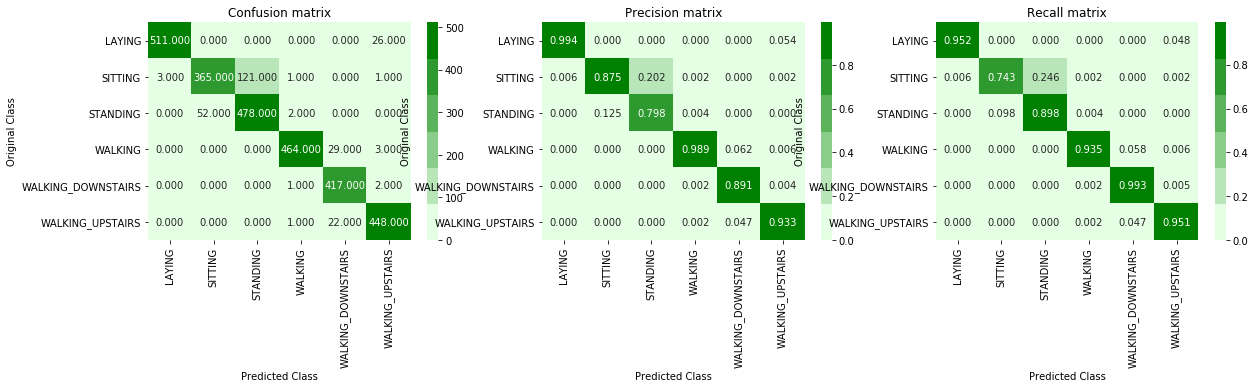

In [23]:
# Confusion Matrix
plot_confusion_matrix(Y_test, best_model2.predict(X_test))

## Observations:

After Hyperparameter tuning loss improved as well as Accuracy is also improved.

If we tune the Dropout rate then our result will more improve.

Model is confused between Sitting and Standing  ,but other results are good.